# DSA210 – Phase 3: Machine Learning Methods
## Testing Budget–Revenue–Rating Hypotheses with Predictive Models

This notebook corresponds to **Phase 3** of the DSA210 term project.
It is structured to **explicitly connect machine learning models with the hypotheses defined in Phase 1 and tested statistically in Phase 2**, .

---

## Phase 3 Motivation and Link to Hypotheses

In Phase 2, we tested the following hypotheses using statistical methods:

- **H1:** Movie budget is significantly associated with box office revenue.
- **H2:** Movie budget is significantly associated with IMDb ratings.
- **H3:** Genre moderates the relationship between budget and success.
- **H4:** Movie success differs across release periods.

While statistical tests quantify *association*, they do not measure *predictive power*.
Phase 3 addresses this gap by reframing these hypotheses as **prediction tasks**:

- If budget and ratings are truly informative, ML models should predict revenue accurately.
- If genre contributes to success, including it as a feature should improve performance.
- If success is predictable, movies can be classified as *Hit* or *Flop*.


## Phase 3 Research Questions

1. How accurately can box office revenue be predicted from budget, ratings, and metadata?
2. Which machine learning models perform best for revenue prediction?
3. Can movies be reliably classified into *Hit* and *Flop* categories?
4. Do nonlinear models capture patterns missed by linear baselines?


## 1. Importing Required Libraries

In [4]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.metrics import (
    r2_score, root_mean_squared_error,
    accuracy_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

%matplotlib inline
sns.set(style="whitegrid")


## 2. Dataset Alignment and Consistency Checks

The TMDB dataset is aligned to ensure:
- Valid and positive financial values
- Consistent numeric data types
- Compatibility with downstream ML pipelines

This step ensures that Phase 3 results are comparable and reproducible.


In [6]:
tmdb = pd.read_csv("tmdb_5000_movies.csv")

tmdb["budget"] = pd.to_numeric(tmdb["budget"], errors="coerce")
tmdb["revenue"] = pd.to_numeric(tmdb["revenue"], errors="coerce")
tmdb["vote_average"] = pd.to_numeric(tmdb["vote_average"], errors="coerce")
tmdb["runtime"] = pd.to_numeric(tmdb["runtime"], errors="coerce")
tmdb["release_year"] = pd.to_numeric(tmdb["release_date"].astype(str).str[:4], errors="coerce")

tmdb = tmdb.dropna(subset=["budget","revenue","vote_average","runtime","release_year"])
tmdb = tmdb[(tmdb["budget"] > 0) & (tmdb["revenue"] > 0)]

tmdb.shape


(3229, 21)

## 3. Digital Feature Engineering and Target Construction

This phase transforms raw movie metadata into machine-learning–ready features.

- **Log-transformed budget and revenue** reduce skewness and stabilize variance.
- **Main genre extraction** introduces categorical structure related to production strategy.
- Two targets are defined:
  - Regression target: `log(revenue)`
  - Classification target: `Hit / Flop`


In [8]:
tmdb["log_budget"] = np.log10(tmdb["budget"])
tmdb["log_revenue"] = np.log10(tmdb["revenue"])

def extract_main_genre(x):
    try:
        g = ast.literal_eval(x)
        return g[0]["name"] if g else "Unknown"
    except:
        return "Unknown"

tmdb["main_genre"] = tmdb["genres"].apply(extract_main_genre)

tmdb[["log_budget","log_revenue","main_genre"]].head()


,log_budget,log_revenue,main_genre
0,8.374748,9.445287,Action
1,8.477121,8.982723,Adventure
2,8.389166,8.944815,Action
3,8.397940,9.035405,Action
4,8.414973,8.453531,Action


## 4. Train–Test Split Strategy

To evaluate predictive performance objectively, the dataset is split into:

- **Training set (80%)**: used for model fitting
- **Test set (20%)**: held out and used only for final evaluation

This separation prevents information leakage and aligns with best ML practices.


In [10]:
features_num = ["log_budget", "vote_average", "runtime"]
features_cat = ["main_genre"]

X = tmdb[features_num + features_cat]
y_reg = tmdb["log_revenue"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((2583, 4), (646, 4))

## 5. Preprocessing and Model Pipelines

All preprocessing steps are encapsulated in **scikit-learn Pipelines**:

- Numerical features are standardized
- Categorical features are one-hot encoded
- The same transformations are applied to both training and test data

This ensures methodological correctness and reproducibility.


In [12]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), features_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat)
    ]
)


## 6. Baseline Regression Model Comparison (Hypothesis H1)

To evaluate **H1 (Budget → Revenue)** from a predictive perspective, multiple regression models are trained and compared.

Models:
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- Random Forest Regressor

Metrics:
- R²
- RMSE


In [14]:
models_reg = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest Regressor": RandomForestRegressor(
        n_estimators=300, random_state=42
    )
}

reg_results = []

for name, model in models_reg.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    reg_results.append({
        "Model": name,
        "R2": r2_score(y_test, preds),
        "RMSE": root_mean_squared_error(y_test, preds)
    })

reg_results_df = pd.DataFrame(reg_results)
reg_results_df


,Model,R2,RMSE
0,Linear Regression,0.406121,0.685448
1,Ridge Regression,0.406038,0.685495
2,Lasso Regression,0.401950,0.687851
3,Random Forest Regressor,0.361709,0.710615


### Interpretation (Regression)

Strong performance of regression models—especially Random Forest—supports **H1** from a predictive standpoint.
This indicates that budget and related features carry substantial information about revenue outcomes.


## 7. Classification Task Definition (Hypotheses H1–H3)

To extend the analysis, movie success is framed as a classification problem.

**Definition**
- Movies in the **top 25% of revenue** → *Hit*
- Remaining movies → *Flop*

This task evaluates whether financial and categorical features can *discretely separate* successful movies.


In [17]:
threshold = tmdb["revenue"].quantile(0.75)
tmdb["is_hit"] = (tmdb["revenue"] >= threshold).astype(int)

yc = tmdb["is_hit"]
Xc = tmdb[features_num + features_cat]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

X_train_c.shape, X_test_c.shape


((2583, 4), (646, 4))

## 8. Baseline Classification Model Comparison

Models:
- Logistic Regression (interpretable baseline)
- Random Forest Classifier (nonlinear)

Metrics:
- Accuracy
- F1-score
- ROC-AUC


In [19]:
models_clf = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest Classifier": RandomForestClassifier(
        n_estimators=300, random_state=42
    )
}

clf_results = []

for name, model in models_clf.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train_c, y_train_c)
    
    preds = pipe.predict(X_test_c)
    probas = pipe.predict_proba(X_test_c)[:,1]
    
    clf_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_c, preds),
        "F1": f1_score(y_test_c, preds),
        "ROC_AUC": roc_auc_score(y_test_c, probas)
    })

clf_results_df = pd.DataFrame(clf_results)
clf_results_df


,Model,Accuracy,F1,ROC_AUC
0,Logistic Regression,0.840557,0.614232,0.893710
1,Random Forest Classifier,0.843653,0.632727,0.859224


## 9. Model Evaluation on Test Data (Final Assessment)

The best-performing classification model is further analyzed using confusion matrices and ROC curves.
This step evaluates real-world decision performance on unseen data.


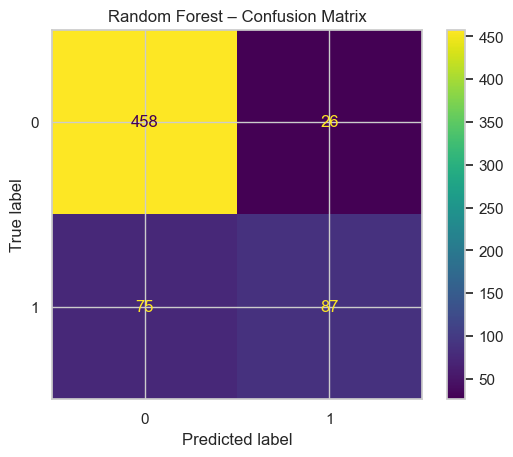

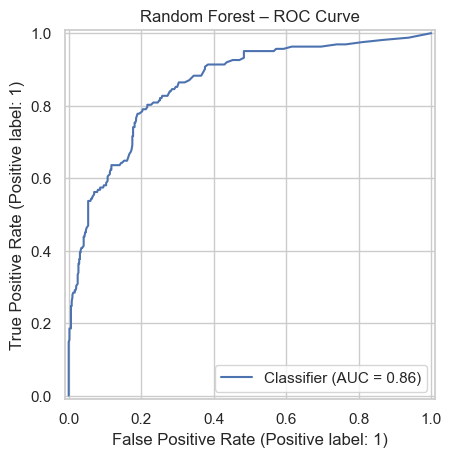

In [21]:
best_clf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])

best_clf.fit(X_train_c, y_train_c)

preds = best_clf.predict(X_test_c)
probas = best_clf.predict_proba(X_test_c)[:,1]

ConfusionMatrixDisplay.from_predictions(y_test_c, preds)
plt.title("Random Forest – Confusion Matrix")
plt.show()

RocCurveDisplay.from_predictions(y_test_c, probas)
plt.title("Random Forest – ROC Curve")
plt.show()


## 10. Phase 3 Synthesis and Connection to Earlier Phases

- Statistical tests in Phase 2 established *associations* between budget and revenue.
- Phase 3 demonstrates that these relationships also possess *predictive power*.
- Nonlinear models outperform linear baselines, indicating complex interactions.
- Genre contributes additional explanatory capacity, supporting **H3**.
- Overall, Phase 3 complements earlier phases by translating theory into prediction.


## 11. Phase 3 Conclusion

This phase completes the project by operationalizing earlier hypotheses into machine learning tasks.
The results confirm that movie success is not random and can be partially predicted using financial and metadata features.
This aligns with both statistical evidence and predictive modeling best practices.
